In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from Algorithms.HelicopterTriggerIndex import *

## Hammerfest 9.12.2019 10:00 UTC

Ble oppringt av GOT 09.12.19 kl 11:00 Local Time. Han sto på Goliat og hadde hatt en røff tur ut dit mtp snøbyger og uvær.

GOT rapporterte å fly mellom heavy snow showers i -3 grader

HTL for 6 + 4, 5

 

In [2]:
ds = xr.open_dataset("https://thredds.met.no/thredds/dodsC/meps25epsarchive/2019/12/09/meps_extracted_2_5km_20191209T06Z.nc").isel(height0=0)

In [ ]:
geo_pl, geo_sf, airtemp_pl, upward_pl, lowcloud, prec = fetchfields(ds,4)

air_temp = get_height_value_from_pl(geo_pl,airtemp_pl-273.15)
W_ = get_height_value_from_pl(geo_pl,upward_pl)


Nbh = 7
W = np.zeros_like(W_)
topomin = np.zeros_like(W)
topomax = np.zeros_like(topomin)
cl = np.zeros_like(lowcloud)
pc = np.zeros_like(prec)

for member in W_["ensemble_member"]:
    W[member] = neighbourhood_max(W_.isel(ensemble_member=member).values,Nbh)
    cl[member] = neighbourhood_max(lowcloud.isel(ensemble_member=member).values,Nbh)
    cl[member] -= neighbourhood_min(lowcloud.isel(ensemble_member=member).values,Nbh)
    pc[member] = neighbourhood_max(prec.isel(ensemble_member=member).values,Nbh)
    topomax[member] = neighbourhood_max(geo_sf.isel(ensemble_member=member).values,Nbh)
    topomin[member] = neighbourhood_min(geo_sf.isel(ensemble_member=member).values,Nbh)

tfunc = temperature_max_band_from_b_to_c(-1,-6)

def only_positive_but_no_larger_than_1(array):
    size = array.shape
    result = np.zeros(size)
    result[np.where(array > 0)] = np.minimum(1.5*array[np.where(array>0)],1)
    return result

def only_positive_but_no_larger_than_1_with_scaling(topoarray,scaling = 15000):
    def f(array):
        size = array.shape
        result = np.zeros(size)
        result[np.where(array > 0) and np.where(topoarray < 10)] = np.minimum(1.5*array[np.where(array>0) and np.where(topoarray < 10)],1)
        scalingfactor = 1-(topoarray[np.where(array>0) and np.where(topoarray>10)]/scaling)
        result[np.where(array > 0) and np.where(topoarray > 10)] = np.minimum(scalingfactor*1.5*array[np.where(array > 0) and np.where(topoarray > 10)],1)
        result[np.where(result < 0)] = 0
        return result
    return f
wfunc = only_positive_but_no_larger_than_1_with_scaling(topomax)
pfunc = only_positive_but_no_larger_than_1
cfunc = lambda x: x

HTI = HelicopterTriggerIndex([tfunc,wfunc,pfunc,cfunc])
result = HTI([air_temp.values,W,pc,cl])

result[np.where(topomax >= 7500)] = 0
result[np.where(topomin >= 10)] = 0
def mask(array,topmax=topomax,topmin=topomin):
    array[np.where(topmax >= 7500)] = 0
    array[np.where(topmin >= 10)] = 0
    return array

T = mask(tfunc(air_temp.values))
Wn = mask(wfunc(W))
P = mask(pfunc(pc))
C = mask(cfunc(cl))

In [ ]:
new_ds = xr.Dataset({'Total_HTI': (["ensemble_member","y", "x"],  result),
                    'Temperature': (["ensemble_member","y", "x"], T),
                    'Upward_velocity': (["ensemble_member","y", "x"],  Wn),
                    'Precipitation': (["ensemble_member","y", "x"],  P),
                    'Cloud_cover': (["ensemble_member","y", "x"],  C)},
                    coords={'lon': (['y', 'x'], ds.longitude),
                            'lat': (['y', 'x'], ds.latitude)})
    

In [8]:
def plot_HTI(da,ax,cbar_ax):
   
    da.plot(levels=[0,.000001,0.7,0.90,0.99,1],vmax=1,ax=ax,cbar_ax = cbar_ax,
              colors=["#a3b8c7","#ffffff", "#fcbd00", "#fc5600", "#fc0000"],
              cbar_kwargs = {
                  "ticks" : [0.000001,0.7,0.9,0.99,1],"label" : "Helicopter Trigger Index - HTI"}
             );
    return ax

In [ ]:
fig,ax = plt.subplots(3,4,figsize=(14,8))
for member in range(10):
    plot_HTI(new_ds["Temperature"].sel(ensemble_member=member).isel(x=range(400,889), y=range(600,949)),
            ax[member//4][member%4],ax[-1][-1])
    ax[member//4][member%4].set_xlabel("")
    ax[member//4][member%4].set_ylabel("")


In [ ]:
fig,ax = plt.subplots(3,4,figsize=(14,8))
for member in range(10):
    plot_HTI(new_ds["Upward_velocity"].sel(ensemble_member=member).isel(x=range(400,889), y=range(600,949)), ax[member//4][member%4],ax[-1][-1])
    ax[member//4][member%4].set_xlabel("")
    ax[member//4][member%4].set_ylabel("")


In [ ]:
fig,ax = plt.subplots(3,4,figsize=(14,8))
for member in range(10):
    plot_HTI(new_ds["Cloud_cover"].sel(ensemble_member=member).isel(x=range(400,889), y=range(600,949)),ax[member//4][member%4],ax[-1][-1])
    ax[member//4][member%4].set_xlabel("")
    ax[member//4][member%4].set_ylabel("")


In [ ]:
fig,ax = plt.subplots(3,4,figsize=(14,8))
for member in range(10):
    plot_HTI(new_ds["Precipitation"].sel(ensemble_member=member).isel(x=range(400,889), y=range(600,949)),ax[member//4][member%4],ax[-1][-1])
    ax[member//4][member%4].set_xlabel("")
    ax[member//4][member%4].set_ylabel("")


In [ ]:
fig,ax = plt.subplots(3,4,figsize=(14,8))
for member in range(10):
    plot_HTI(new_ds["Total_HTI"].sel(ensemble_member=member).isel(x=range(400,889), y=range(600,949)),ax[member//4][member%4],ax[-1][-1])
    ax[member//4][member%4].set_xlabel("")
    ax[member//4][member%4].set_ylabel("")


## Kristiansund 23.10.2018


In [8]:
HTI_ds 


<xarray.Dataset>
Dimensions:                     (time: 67, x: 869, y: 929)
Coordinates:
  * time                        (time) datetime64[ns] 2018-10-23 ... 2018-10-25T18:00:00
  * x                           (x) float32 -997485.4 -994985.4 ... 1172514.6
  * y                           (y) float32 -1104330.6 -1101830.6 ... 1215669.4
    longitude                   (y, x) float64 ...
    latitude                    (y, x) float64 ...
Data variables:
    helicopter_triggered_index  (time, y, x) float32 ...

In [9]:
def plot_HTI(da,ax):
   
    da.plot(levels=[0,.000001,0.7,0.90,0.99,1],vmin=0.0000001,vmax=1,ax=ax,
              colors=["#a3b8c7","#ffffff", "#fcbd00", "#fc5600", "#fc0000"],
              cbar_kwargs = {
                  "ticks" : [0.000001,0.7,0.9,0.99,1],"label" : "Helicopter Trigger Index - HTI"}
             );
    return ax


In [5]:
plot_HTI(HTI_ds)

TypeError: plot_HTI() missing 1 required positional argument: 'ax'

In [32]:
prec1 = ext_ds
prec = (ext_ds- ext_ds.shift({"time":1},fill_value=0))


In [33]:
prec1 = prec1.isel(height0=0)
prec = prec.isel(height0=0)

In [34]:
P = np.zeros(prec.values.shape)
old_prec = np.zeros(prec.values.shape)
for time in range(prec.values.shape[0]):
    old_prec[time] = neighbourhood_max(prec1.values[time],Nbh)
    old_prec[time] = only_positive_but_no_larger_than_1(old_prec[time])
    P[time] = neighbourhood_max(prec.values[time],Nbh)
    P[time] = only_positive_but_no_larger_than_1(P[time])


In [35]:
P,old_prec = P[:,10:-10,10:-10],old_prec[:,10:-10,10:-10]
HTI_fixed = (HTI_ds["helicopter_triggered_index"].isel(time=range(0,25)) - old_prec/4) + P/4


NameError: name 'HTI_fixed' is not defined

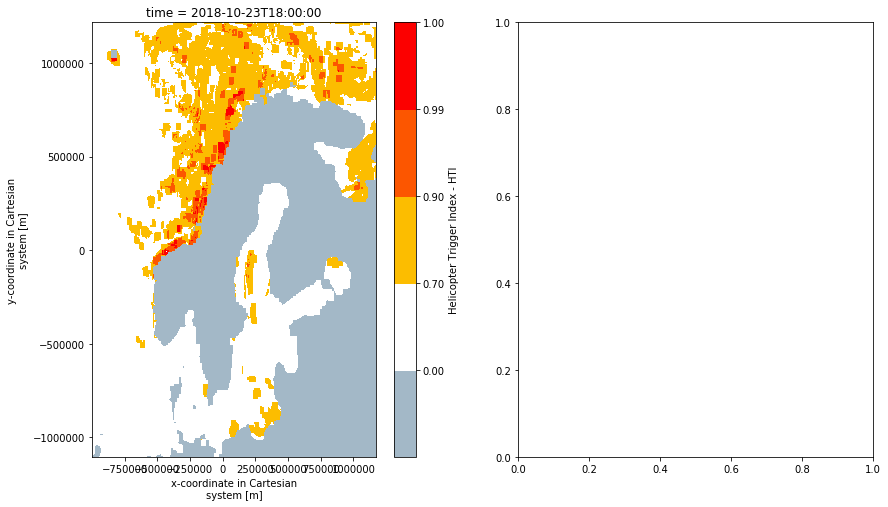

In [6]:
fig,ax = plt.subplots(ncols=2,figsize=(14,8))

plot_HTI(HTI_ds["helicopter_triggered_index"].isel(time=18),ax=ax[0])
plot_HTI(HTI_fixed.isel(time=18),ax=ax[1])


In [5]:
def part_forecast_extracted(ds):
    xarray = ds.isel(height0 = 0)
    prec1 = xarray["precipitation_amount_acc"].isel(time = range(1,7))
    prec = (xarray["precipitation_amount_acc"]- xarray["precipitation_amount_acc"].shift({"time":1},fill_value=0)).isel(time = range(1,7))
    P = np.zeros(prec.values.shape)
    old_prec = np.zeros(prec.values.shape)
    for time in range(prec.values.shape[0]):
        old_prec[time] = neighbourhood_max(prec1.values[time],Nbh)
        old_prec[time] = only_positive_but_no_larger_than_1(old_prec[time])
        P[time] = neighbourhood_max(prec.values[time],Nbh)
        P[time] = only_positive_but_no_larger_than_1(P[time])
    return P[:,10:-10,10:-10],old_prec[:,10:-10,10:-10]
part_forecast_extracted(ext_ds)

KeyboardInterrupt: 